In [5]:
import os

BASE = "/kaggle/input/datasets/tahmimahoque/depression-detection-speech-dataset/Depression_det"

print("Malayalam dep train:", len(os.listdir(BASE + "/Malayalam/Malayalam/Depressed/Train_set")))
print("Malayalam nondep train:", len(os.listdir(BASE + "/Malayalam/Malayalam/Non_depressed/Train_set")))
print("Tamil dep train:", len(os.listdir(BASE + "/Tamil/Tamil/Depressed/Train_set")))
print("Tamil nondep train:", len(os.listdir(BASE + "/Tamil/Tamil/Non-depressed/Train_set")))
print("Malayalam test:", len(os.listdir(BASE + "/Test_set_mal/Test_set_mal")))
print("Tamil test:", len(os.listdir(BASE + "/Test-set-tamil/Test-set-tamil")))

Malayalam dep train: 788
Malayalam nondep train: 900
Tamil dep train: 454
Tamil nondep train: 920
Malayalam test: 200
Tamil test: 160


# Reproducibility

Random seeds are fixed for Python, NumPy, and PyTorch to ensure deterministic and reproducible results. CUDA determinism is enabled, and a worker seed function is used for DataLoader consistency

In [6]:
import os, random
import numpy as np
import torch

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: stronger determinism (may error if some ops are nondeterministic)
# torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


# Resampling

Resamples Malayalam depression dataset audio to 16 kHz mono while preserving folder structure and logging errors.

In [7]:
import os, glob, logging
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm

# -----------------------------
# Paths (Kaggle)
# -----------------------------
BASE = "/kaggle/input/datasets/tahmimahoque/depression-detection-speech-dataset/Depression_det"

RAW_ROOT = os.path.join(BASE, "Malayalam", "Malayalam")      # contains Depressed/ and Non_depressed/
OUT_ROOT = "/kaggle/working/data/Malayalam_16k"              # writable output
os.makedirs(OUT_ROOT, exist_ok=True)

# -----------------------------
# Logging
# -----------------------------
logging.basicConfig(
    filename="resample_errors.log",
    level=logging.ERROR,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

def resample_audio(in_path, out_path, target_sr=16000):
    """
    - Load mono
    - Resample to 16k if needed
    - Avoid peak normalization (prevents amplifying noise / removing energy cues)
    - Basic guards for empty / silent audio
    """
    try:
        y, sr = librosa.load(in_path, sr=None, mono=True)

        if y is None or len(y) == 0:
            raise ValueError("Empty audio")

        if float(np.sqrt(np.mean(y**2))) < 1e-6:
            raise ValueError("Near-silent audio")

        if sr != target_sr:
            try:
                y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="soxr_hq")
            except Exception:
                y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="kaiser_best")

        y = np.clip(y, -1.0, 1.0)

        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        sf.write(out_path, y, target_sr)

    except Exception as e:
        logging.error(f"Error processing {in_path}: {e}")
        print(f"[Resample error] {in_path} -> {e}")

def process_folder(src_folder, dst_folder):
    wav_files = glob.glob(os.path.join(src_folder, "**/*.wav"), recursive=True)
    if len(wav_files) == 0:
        print(f"[Skip] No wav files found in: {src_folder}")
        return

    for in_path in tqdm(wav_files, desc=f"Resampling {os.path.basename(src_folder)}"):
        # Preserve any nested structure (even if currently flat)
        rel = os.path.relpath(in_path, src_folder)
        out_path = os.path.join(dst_folder, rel)

        if os.path.exists(out_path):
            continue

        resample_audio(in_path, out_path, target_sr=16000)

# -----------------------------
# Run
# -----------------------------
pairs = [
    ("Depressed", "Depressed"),
    ("Non_depressed", "Non_depressed"),
]

for src_sub, dst_sub in pairs:
    src_path = os.path.join(RAW_ROOT, src_sub)
    dst_path = os.path.join(OUT_ROOT, dst_sub)
    process_folder(src_path, dst_path)

print("\n✅ Resampling complete! Output root:", OUT_ROOT)
print("Check errors in: resample_errors.log")


Resampling Non_depressed: 100%|██████████| 900/900 [00:23<00:00, 37.93it/s]


✅ Resampling complete! Output root: /kaggle/working/data/Malayalam_16k
Check errors in: resample_errors.log


In [8]:
import os, glob
import pandas as pd

DATA_ROOT = "/kaggle/working/data/Malayalam_16k"

rows = []

def collect(folder, label):
    files = glob.glob(os.path.join(folder, "**/*.wav"), recursive=True)
    for f in files:
        rows.append({
            "file_path": f,
            "label": label,
            "fname": os.path.splitext(os.path.basename(f))[0]
        })

collect(os.path.join(DATA_ROOT, "Depressed"), 1)
collect(os.path.join(DATA_ROOT, "Non_depressed"), 0)

df = pd.DataFrame(rows)
assert len(df) > 0, "No wav files found. Check DATA_ROOT and your resampling output."

# Deterministic shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

metadata_path = os.path.join(DATA_ROOT, "malayalam_metadata.csv")
df.to_csv(metadata_path, index=False)

print("✅ CSV saved at:", metadata_path)
print(df.head())
print("\nLabel counts:")
print(df["label"].value_counts())
print("\nTotal files:", len(df))

✅ CSV saved at: /kaggle/working/data/Malayalam_16k/malayalam_metadata.csv
                                           file_path  label        fname
0  /kaggle/working/data/Malayalam_16k/Non_depress...      0     ND4_0039
1  /kaggle/working/data/Malayalam_16k/Depressed/T...      1    D_S0020_b
2  /kaggle/working/data/Malayalam_16k/Depressed/T...      1  D_F001_48_4
3  /kaggle/working/data/Malayalam_16k/Depressed/T...      1  D_F001_45_1
4  /kaggle/working/data/Malayalam_16k/Non_depress...      0     ND2_0129

Label counts:
label
0    900
1    788
Name: count, dtype: int64

Total files: 1688


# Sanity Check of Data


In [9]:
import os, re
import numpy as np
import pandas as pd
import soundfile as sf
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit

# -----------------------------
# Load metadata
# -----------------------------
DATA_ROOT = "/kaggle/working/data/Malayalam_16k"
csv_path = os.path.join(DATA_ROOT, "malayalam_metadata.csv")

df = pd.read_csv(csv_path)
print("Loaded CSV:", len(df))

# -----------------------------
# Speaker & utterance parsing (TAILORED)
# -----------------------------
def extract_speaker(fname):
    """
    Examples:
    D_F001_25_1  -> D_F001
    D_A032_4    -> D_A032
    ND3_0133    -> ND3
    ND1_0009    -> ND1
    """
    parts = fname.split("_")
    if fname.startswith("ND"):
        return parts[0]            # ND1, ND3, ...
    if fname.startswith("D_"):
        return "_".join(parts[:2]) # D_F001, D_A032, ...
    return parts[0]                # fallback

def extract_utt_base(fname):
    """
    Removes repeat suffix:
    D_F001_25_1  -> D_F001_25
    D_F001_64_3  -> D_F001_64
    ND3_0133    -> ND3_0133
    """
    return re.sub(r"_\d+$", "", fname)

df["speaker"] = df["fname"].apply(extract_speaker)
df["utt_base"] = df["fname"].apply(extract_utt_base)

# -----------------------------
# Basic dataset stats
# -----------------------------
print("\n[Label distribution]")
print(df["label"].value_counts())

print("\n[Unique speakers per class]")
print(df.groupby("label")["speaker"].nunique().rename({0:"Non-depressed", 1:"Depressed"}))

print("\n[Top speakers by sample count]")
print(df["speaker"].value_counts().head(10))

# -----------------------------
# Repeat-utterance analysis
# -----------------------------
repeat_counts = (
    df.groupby(["speaker", "utt_base"])
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)

repeats = repeat_counts[repeat_counts["count"] > 1]

print("\n[Repeated utterances by same speaker]")
print("Number of repeated (speaker, utt_base) pairs:", len(repeats))
if len(repeats) > 0:
    print(repeats.head(10))

# -----------------------------
# Audio health checks
# -----------------------------
def audio_stats(path):
    try:
        info = sf.info(path)
        sr = info.samplerate
        dur = info.frames / float(sr)

        y, _ = sf.read(path, dtype="float32", always_2d=False)
        if y.ndim > 1:
            y = np.mean(y, axis=1)

        sil_ratio = float(np.mean(np.abs(y) < 1e-4))
        rms = float(np.sqrt(np.mean(y**2)) + 1e-12)

        return sr, dur, sil_ratio, rms, None
    except Exception as e:
        return None, None, None, None, str(e)

rows = []
for p in tqdm(df["file_path"], desc="Scanning audio"):
    rows.append(audio_stats(p))

df[["sr","dur_sec","sil_ratio","rms","err"]] = pd.DataFrame(rows, index=df.index)

print("\n[Read errors]:", df["err"].notna().sum())

print("\n[Sample rate distribution]")
print(df["sr"].value_counts())

print("\n[Duration stats (sec)]")
print(df["dur_sec"].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

print("\n[Silence ratio stats]")
print(df["sil_ratio"].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

print("\n[Potential issues]")
print("Too short (<0.3s):", (df["dur_sec"] < 0.3).sum())
print("Very silent (sil_ratio > 0.98):", (df["sil_ratio"] > 0.98).sum())

# -----------------------------
# Speaker-safe split simulation
# -----------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df, y=df["label"], groups=df["speaker"]))

train_df = df.iloc[train_idx]
val_df   = df.iloc[val_idx]

speaker_overlap = set(train_df["speaker"]).intersection(set(val_df["speaker"]))
utt_overlap = set(zip(train_df["speaker"], train_df["utt_base"])) & \
              set(zip(val_df["speaker"], val_df["utt_base"]))

print("\n[Speaker-safe split check]")
print("Train speakers:", train_df["speaker"].nunique())
print("Val speakers:", val_df["speaker"].nunique())
print("Speaker overlap:", len(speaker_overlap))

print("Overlap of (speaker, utt_base) across splits:", len(utt_overlap))
if len(utt_overlap) > 0:
    print("Example overlaps:", list(utt_overlap)[:10])

print("\n✅ Sanity check done.")


Loaded CSV: 1688

[Label distribution]
label
0    900
1    788
Name: count, dtype: int64

[Unique speakers per class]
label
Non-depressed      5
Depressed        127
Name: speaker, dtype: int64

[Top speakers by sample count]
speaker
D_F001     284
ND4        180
ND2        180
ND5        180
ND1        180
ND3        180
D_S0020      4
D_A018       4
D_S0052      4
D_S0049      4
Name: count, dtype: int64

[Repeated utterances by same speaker]
Number of repeated (speaker, utt_base) pairs: 138
    speaker utt_base  count
389     ND1      ND1    180
392     ND4      ND4    180
390     ND2      ND2    180
391     ND3      ND3    180
393     ND5      ND5    180
28   D_A029   D_A029      4
26   D_A027   D_A027      4
27   D_A028   D_A028      4
24   D_A025   D_A025      4
25   D_A026   D_A026      4


Scanning audio: 100%|██████████| 1688/1688 [00:01<00:00, 1150.78it/s]


[Read errors]: 0

[Sample rate distribution]
sr
16000    1688
Name: count, dtype: int64

[Duration stats (sec)]
count    1688.000000
mean        4.714041
std         1.417860
min         1.522625
1%          1.979884
5%          2.449813
50%         4.644813
95%         6.943516
99%         8.261785
max        10.360875
Name: dur_sec, dtype: float64

[Silence ratio stats]
count    1688.000000
mean        0.052202
std         0.100364
min         0.000746
1%          0.000975
5%          0.001190
50%         0.005252
95%         0.294750
99%         0.388547
max         0.579842
Name: sil_ratio, dtype: float64

[Potential issues]
Too short (<0.3s): 0
Very silent (sil_ratio > 0.98): 0

[Speaker-safe split check]
Train speakers: 105
Val speakers: 27
Speaker overlap: 0
Overlap of (speaker, utt_base) across splits: 0

✅ Sanity check done.


In [10]:
import re
import pandas as pd

df = pd.read_csv("/kaggle/working/data/Malayalam_16k/malayalam_metadata.csv")

def extract_speaker(fname):
    # Non-depressed speakers: ND1, ND2, ...
    m = re.match(r"^(ND\d+)_", fname, flags=re.IGNORECASE)
    if m:
        return m.group(1).upper()

    # Depressed: we want REAL speaker IDs like D_F001, D_M002, D_S005 etc
    # (exclude D_A032 which looks like utterance ID)
    m = re.match(r"^(D)_([FMS]\d{3})_", fname, flags=re.IGNORECASE)
    if m:
        return f"{m.group(1).upper()}_{m.group(2).upper()}"

    # If it's depressed but doesn't match known speaker pattern, bucket it
    if fname.upper().startswith("D_"):
        return "D_OTHER"

    return "UNKNOWN"

def extract_utt_base(fname):
    # remove trailing repeat suffix _1/_2/_3 etc (ONLY at end)
    return re.sub(r"_\d+$", "", fname.upper())

df["speaker_fixed"] = df["fname"].apply(extract_speaker)
df["utt_base_fixed"] = df["fname"].apply(extract_utt_base)

print("Unique speakers per class (fixed):")
print(df.groupby("label")["speaker_fixed"].nunique().rename({0:"Non-depressed", 1:"Depressed"}))

print("\nTop speakers (fixed):")
print(df["speaker_fixed"].value_counts().head(20))

print("\nHow many D_OTHER?")
print((df["speaker_fixed"]=="D_OTHER").sum())


Unique speakers per class (fixed):
label
Non-depressed     5
Depressed        11
Name: speaker_fixed, dtype: int64

Top speakers (fixed):
speaker_fixed
D_OTHER    477
D_F001     284
ND4        180
ND2        180
ND5        180
ND3        180
ND1        180
D_S004       3
D_S006       3
D_S009       3
D_S001       3
D_S007       3
D_S003       3
D_S002       3
D_S005       3
D_S008       3
Name: count, dtype: int64

How many D_OTHER?
477


# Speaker-Aware Leakage-Free Train–Validation Split
Creates speaker-aware, leakage-free stratified train–validation splits for the Malayalam dataset using grouped cross-validation.

In [12]:

import os, re
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold

# ✅ Kaggle working paths
IN_PATH  = "/kaggle/working/data/Malayalam_16k/malayalam_metadata.csv"
OUT_PATH = "/kaggle/working/data/Malayalam_16k/malayalam_metadata_with_split.csv"

df = pd.read_csv(IN_PATH)

# ---------- same parsing as before ----------
def extract_speaker(fname):
    m = re.match(r"^(ND\d+)_", fname, flags=re.IGNORECASE)
    if m: 
        return m.group(1).upper()

    m = re.match(r"^(D)_([FMS]\d{3})_", fname, flags=re.IGNORECASE)
    if m:
        return f"{m.group(1).upper()}_{m.group(2).upper()}"

    if fname.upper().startswith("D_"):
        return "D_OTHER"

    return "UNKNOWN"

def utt_base(fname):
    return re.sub(r"_\d+$", "", fname.upper())

df["speaker_fixed"] = df["fname"].apply(extract_speaker)
df["utt_base_fixed"] = df["fname"].apply(utt_base)

def make_group(row):
    if row["label"] == 0:  # non-depressed
        return row["speaker_fixed"]          # ND1..ND5
    if row["speaker_fixed"] != "D_OTHER":
        return row["speaker_fixed"]          # D_F001, D_S###
    return "DUTT_" + row["utt_base_fixed"]   # prevent repeat leakage

df["group_id"] = df.apply(make_group, axis=1)

overall_ratio = df["label"].mean()
print("Overall depressed ratio:", overall_ratio)

# ---------- try folds and score them ----------
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

candidates = []
X = np.zeros((len(df), 1))  # dummy X for sklearn

for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, df["label"], groups=df["group_id"])):
    val = df.iloc[val_idx]
    train = df.iloc[train_idx]

    val_counts = val["label"].value_counts().to_dict()
    train_counts = train["label"].value_counts().to_dict()

    val_size = len(val)
    has_both = (0 in val_counts) and (1 in val_counts)
    val_ratio = val["label"].mean() if val_size > 0 else 0.0

    score = abs(val_ratio - overall_ratio)
    if not has_both:
        score += 10.0
    if val_size < 200:
        score += (200 - val_size) / 50.0

    candidates.append((score, fold, val_size, val_counts, val_ratio, train_counts))

print("\nFold candidates:")
for score, fold, val_size, val_counts, val_ratio, train_counts in sorted(candidates, key=lambda x: x[0]):
    print(f"fold={fold}  score={score:.3f}  val_size={val_size}  val_counts={val_counts}  val_ratio={val_ratio:.3f}")

best = sorted(candidates, key=lambda x: x[0])[0]
_, best_fold, *_ = best
print("\n✅ Choosing best fold:", best_fold)

# rerun to get indices for chosen fold
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, df["label"], groups=df["group_id"])):
    if fold == best_fold:
        break

df["split"] = "train"
df.loc[val_idx, "split"] = "val"

# verify group overlap
train_df = df[df["split"]=="train"]
val_df = df[df["split"]=="val"]
overlap = set(train_df["group_id"]) & set(val_df["group_id"])
print("Group overlap:", len(overlap))

print("\nTrain label counts:")
print(train_df["label"].value_counts(), " Train ratio:", train_df["label"].mean())

print("\nVal label counts:")
print(val_df["label"].value_counts(), " Val ratio:", val_df["label"].mean())

df.to_csv(OUT_PATH, index=False)
print("\n✅ Saved split CSV:", OUT_PATH)


Overall depressed ratio: 0.466824644549763

Fold candidates:
fold=1  score=0.051  val_size=308  val_counts={0: 180, 1: 128}  val_ratio=0.416
fold=2  score=0.059  val_size=304  val_counts={0: 180, 1: 124}  val_ratio=0.408
fold=3  score=0.209  val_size=485  val_counts={0: 360, 1: 125}  val_ratio=0.258
fold=4  score=0.225  val_size=584  val_counts={1: 404, 0: 180}  val_ratio=0.692
fold=0  score=14.393  val_size=7  val_counts={1: 7}  val_ratio=1.000

✅ Choosing best fold: 1
Group overlap: 0

Train label counts:
label
0    720
1    660
Name: count, dtype: int64  Train ratio: 0.4782608695652174

Val label counts:
label
0    180
1    128
Name: count, dtype: int64  Val ratio: 0.4155844155844156

✅ Saved split CSV: /kaggle/working/data/Malayalam_16k/malayalam_metadata_with_split.csv


# MFCC

In [13]:
# =============================
# 0️⃣ Seeds (strong + dataloader-safe)
# =============================
import os, random
import numpy as np
import torch

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================
# 1️⃣ Imports
# =============================
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import librosa

# =============================
# 2️⃣ Load leak-safe split CSV
# =============================
data_root = "/kaggle/working/data/Malayalam_16k"

split_csv = os.path.join(data_root, "malayalam_metadata_with_split.csv")
df = pd.read_csv(split_csv)

train_df = df[df["split"]=="train"].reset_index(drop=True)
val_df   = df[df["split"]=="val"].reset_index(drop=True)

print("Train:", len(train_df), " Val:", len(val_df))
print("Train label ratio:", train_df["label"].mean(), " Val label ratio:", val_df["label"].mean())

# =============================
# 3️⃣ MFCC extraction (+ optional SpecAugment-like masks)
# =============================
def extract_mfcc_2d(file_path, sr=16000, n_mfcc=20, max_frames=120,
                    n_fft=400, hop_length=160):
    """
    n_fft=400, hop=160 -> ~25ms window, 10ms hop at 16kHz (standard speech setup)
    max_frames ~ 120 => ~1.2 sec of frames if hop=10ms (but depends on trimming).
    We will pad/truncate to max_frames after feature extraction.
    """
    y, _ = librosa.load(file_path, sr=sr, mono=True)

    # Optional: trim very long audio to reduce overfit on duration
    # keep first ~6 seconds (tune later)
    max_samples = sr * 6
    if len(y) > max_samples:
        y = y[:max_samples]

    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=n_mfcc,
        n_fft=n_fft, hop_length=hop_length
    )  # (n_mfcc, T)

    # Pad/truncate time axis
    T = mfcc.shape[1]
    if T < max_frames:
        mfcc = np.pad(mfcc, ((0,0),(0,max_frames-T)), mode="constant")
    else:
        mfcc = mfcc[:, :max_frames]

    # Per-sample normalization (good for MFCC)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-9)

    return mfcc.astype(np.float32)  # 2D

def time_freq_mask(mfcc_2d, max_time_mask=12, max_freq_mask=4, p=0.5):
    """
    Light SpecAugment-style masking on MFCC.
    """
    if random.random() > p:
        return mfcc_2d

    mfcc = mfcc_2d.copy()
    n_mfcc, T = mfcc.shape

    # time mask
    t = random.randint(0, max_time_mask)
    if t > 0:
        t0 = random.randint(0, max(0, T - t))
        mfcc[:, t0:t0+t] = 0.0

    # freq mask
    f = random.randint(0, max_freq_mask)
    if f > 0:
        f0 = random.randint(0, max(0, n_mfcc - f))
        mfcc[f0:f0+f, :] = 0.0

    return mfcc

# =============================
# 4️⃣ Dataset
# =============================
class MFCCDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["file_path"]
        label = int(row["label"])

        mfcc = extract_mfcc_2d(path)

        if self.augment:
            mfcc = time_freq_mask(mfcc, p=0.6)

        # flatten for MLP
        x = torch.tensor(mfcc.reshape(-1), dtype=torch.float32)
        y = torch.tensor(label, dtype=torch.long)
        return x, y

train_ds = MFCCDataset(train_df, augment=True)
val_ds   = MFCCDataset(val_df, augment=False)

train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=2, worker_init_fn=seed_worker, generator=g,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False,
    num_workers=2, worker_init_fn=seed_worker, generator=g,
    pin_memory=True
)

# =============================
# 5️⃣ Class weights
# =============================
train_labels = train_df["label"].values
class_weights = compute_class_weight("balanced", classes=np.array([0,1]), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# =============================
# 6️⃣ MFCC model (MLP + strong regularization)
# =============================
class MFCC_MLP(nn.Module):
    def __init__(self, input_dim=20*120, hidden=128, drop=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, 2)
        )

    def forward(self, x):
        return self.net(x)

model = MFCC_MLP().to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-2)

# =============================
# 7️⃣ Train + Early stopping on macro-F1
# =============================
best_f1 = -1.0
best_state = None
patience = 5
bad = 0
epochs = 30

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # helps stability
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / max(1, len(train_loader))

    # ---- validate
    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            p = torch.argmax(logits, dim=1)
            preds.extend(p.cpu().numpy().tolist())
            gold.extend(y.cpu().numpy().tolist())

    val_f1 = f1_score(gold, preds, average="macro")

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_macroF1={val_f1:.4f}")

    if val_f1 > best_f1 + 1e-4:
        best_f1 = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

# load best
model.load_state_dict(best_state)
print("\n✅ Best MFCC Val macro-F1:", best_f1)

# after you have best_state
torch.save(best_state, "/kaggle/working/mfcc_mlp.pt")
print("✅ Saved MFCC at /kaggle/working/mfcc_mlp.pt")



Train: 1380  Val: 308
Train label ratio: 0.4782608695652174  Val label ratio: 0.4155844155844156
Epoch 01 | train_loss=0.4969 | val_macroF1=0.9933
Epoch 02 | train_loss=0.1687 | val_macroF1=0.9801
Epoch 03 | train_loss=0.1237 | val_macroF1=0.9801
Epoch 04 | train_loss=0.1288 | val_macroF1=0.9967
Epoch 05 | train_loss=0.0994 | val_macroF1=0.9933
Epoch 06 | train_loss=0.0790 | val_macroF1=0.9669
Epoch 07 | train_loss=0.0633 | val_macroF1=0.9247
Epoch 08 | train_loss=0.0621 | val_macroF1=0.9933
Epoch 09 | train_loss=0.0538 | val_macroF1=0.9933
Early stopping.

✅ Best MFCC Val macro-F1: 0.9966617170480041
✅ Saved MFCC at /kaggle/working/mfcc_mlp.pt


# Wev2Vec2

In [14]:
# =============================
# 0️⃣ Seeds + imports
# =============================
import os, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import librosa

from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data import Dataset

from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    set_seed
)

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================
# 1️⃣ Load leak-safe split CSV
# =============================

data_root = "/kaggle/working/data/Malayalam_16k"
split_csv = os.path.join(data_root, "malayalam_metadata_with_split.csv")
df = pd.read_csv(split_csv)

train_df = df[df["split"]=="train"].reset_index(drop=True)
val_df   = df[df["split"]=="val"].reset_index(drop=True)

print("Train:", len(train_df), " Val:", len(val_df))
print("Train label ratio:", train_df["label"].mean(), " Val label ratio:", val_df["label"].mean())

# =============================
# 2️⃣ (Mild) augmentation for training only
# =============================
def augment_audio(y, sr):
    y = np.asarray(y, dtype=np.float32)
    if y.ndim > 1:
        y = np.mean(y, axis=-1)

    # mild speed
    if random.random() < 0.5:
        rate = np.random.uniform(0.95, 1.05)
        y = librosa.effects.time_stretch(y=y, rate=rate)

    # mild pitch
    if random.random() < 0.5:
        n_steps = np.random.uniform(-1.0, 1.0)
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    # mild noise
    if random.random() < 0.5 and y.size > 0:
        noise_amp = 0.001 * np.random.uniform() * max(1e-6, float(np.max(np.abs(y))))
        y = y + noise_amp * np.random.normal(size=y.shape[0]).astype(np.float32)

    return y.astype(np.float32)

# =============================
# 3️⃣ Dataset (truncate to max_seconds)
# =============================
class MalayalamWav2Vec2Dataset(Dataset):
    def __init__(self, df, max_seconds=6.0, augment=False, sr=16000):
        self.df = df.reset_index(drop=True)
        self.max_len = int(max_seconds * sr)
        self.augment = augment
        self.sr = sr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["file_path"]
        label = int(row["label"])

        y, _ = librosa.load(path, sr=self.sr, mono=True)

        # truncate / pad in raw space (padding will be handled by processor)
        if len(y) > self.max_len:
            y = y[:self.max_len]

        if self.augment:
            y = augment_audio(y, self.sr)
            # clip safety
            y = np.clip(y, -1.0, 1.0)

        return {"input_values": y, "labels": label}

train_dataset = MalayalamWav2Vec2Dataset(train_df, augment=True)
val_dataset   = MalayalamWav2Vec2Dataset(val_df, augment=False)

# =============================
# 4️⃣ Processor + model
# =============================
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2,
    problem_type="single_label_classification"
)

# Freeze encoder initially (prevents overfit)
for p in model.wav2vec2.parameters():
    p.requires_grad = False

# slightly higher dropout
model.config.hidden_dropout_prob = 0.2
model.config.attention_dropout = 0.2

model.to(device)

# =============================
# 5️⃣ Data collator
# =============================
def data_collator(batch):
    audio = [b["input_values"] for b in batch]
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)

    inputs = processor(
        audio,
        sampling_rate=16000,
        padding=True,
        return_tensors="pt"
    )
    inputs["labels"] = labels
    return inputs

# =============================
# 6️⃣ Metrics
# =============================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, preds, average="macro")}

# =============================
# 7️⃣ Weighted-loss Trainer (correct way)
# =============================
train_labels = train_df["label"].values
class_weights = compute_class_weight("balanced", classes=np.array([0,1]), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**{k:v for k,v in inputs.items() if k!="labels"})
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels.to(logits.device))
        return (loss, outputs) if return_outputs else loss

# =============================
# 8️⃣ Training args
# =============================
training_args = TrainingArguments(
    output_dir="./wav2vec2_model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,   # effective batch 8 (more stable)
    num_train_epochs=15,
    learning_rate=3e-4,              # higher since encoder is frozen
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=25,
    save_strategy="epoch",
    eval_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    max_grad_norm=1.0,
    fp16=torch.cuda.is_available(),
    seed=SEED,
    data_seed=SEED,
)

# =============================
# 9️⃣ Train
# =============================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

# =============================
# 10️⃣ Final eval (val)
# =============================
metrics = trainer.evaluate()
print("\n✅ Wav2Vec2 Val F1:", metrics["eval_f1"])




Train: 1380  Val: 308
Train label ratio: 0.4782608695652174  Val label ratio: 0.4155844155844156


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     | 
-----------------------------+------------+-
quantizer.weight_proj.bias   | UNEXPECTED | 
project_q.weight             | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
project_hid.weight           | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
project_q.bias               | UNEXPECTED | 
classifier.weight            | MISSING    | 
projector.bias               | MISSING    | 
classifier.bias              | MISSING    | 
projector.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,F1
1,1.192762,0.539525,0.868886
2,0.353097,0.259738,0.892448
3,0.100007,0.162296,0.947332
4,0.051018,0.233902,0.895664
5,0.060708,0.121691,0.957104
6,0.045363,0.052139,0.990007
7,0.039116,0.063817,0.986690
8,0.028528,0.069985,0.990007
9,0.024441,0.097692,0.966917


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Wav2Vec2 Val F1: 0.9900068135362253


In [15]:
# =============================
# 11️⃣ Save best model + processor
# =============================
save_dir = "/kaggle/working/w2v2_best"

trainer.save_model(save_dir)      # saves model + config
processor.save_pretrained(save_dir)

print("✅ Saved Wav2Vec2 model + processor to:", save_dir)

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Saved Wav2Vec2 model + processor to: /kaggle/working/w2v2_best


# Ensemble Weight Tuning & Validation

Tunes and evaluates an MFCC–Wav2Vec2 ensemble on the validation set to select optimal weighting and enable final depression prediction.

In [16]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import librosa
from sklearn.metrics import f1_score
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# Paths
# -----------------------------
SPLIT_CSV = "/kaggle/working/data/Malayalam_16k/malayalam_metadata_with_split.csv"
MFCC_WEIGHTS_PATH = "/kaggle/working/mfcc_mlp.pt"
W2V2_DIR = "/kaggle/working/w2v2_best"

assert os.path.exists(SPLIT_CSV), f"Missing: {SPLIT_CSV}"
assert os.path.exists(MFCC_WEIGHTS_PATH), f"Missing: {MFCC_WEIGHTS_PATH}"
assert os.path.isdir(W2V2_DIR), f"Missing dir: {W2V2_DIR}"


# -----------------------------
# Load VAL split
# -----------------------------
df = pd.read_csv(SPLIT_CSV)
val_df = df[df["split"] == "val"].reset_index(drop=True)
print("Val size:", len(val_df), " Val ratio:", float(val_df["label"].mean()))

# -----------------------------
# MFCC extractor (match training)
# -----------------------------
def extract_mfcc_2d(file_path, sr=16000, n_mfcc=20, max_frames=120, n_fft=400, hop_length=160):
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    max_samples = sr * 6
    if len(y) > max_samples:
        y = y[:max_samples]

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    T = mfcc.shape[1]
    if T < max_frames:
        mfcc = np.pad(mfcc, ((0,0),(0,max_frames-T)), mode="constant")
    else:
        mfcc = mfcc[:, :max_frames]

    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-9)
    return mfcc.astype(np.float32)

# -----------------------------
# MFCC model class (match training)
# -----------------------------
class MFCC_MLP(nn.Module):
    def __init__(self, input_dim=20*120, hidden=128, drop=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, 2)
        )
    def forward(self, x):
        return self.net(x)

# -----------------------------
# Load MFCC model
# -----------------------------
mfcc_model = MFCC_MLP().to(device)
mfcc_model.load_state_dict(torch.load(MFCC_WEIGHTS_PATH, map_location=device))
mfcc_model.eval()
print("✅ MFCC loaded")

# -----------------------------
# Load W2V2 model + processor
# -----------------------------
wav2vec_model = Wav2Vec2ForSequenceClassification.from_pretrained(W2V2_DIR).to(device)
processor = Wav2Vec2Processor.from_pretrained(W2V2_DIR)
wav2vec_model.eval()
print("✅ W2V2 loaded")

# -----------------------------
# Probability functions
# -----------------------------
@torch.no_grad()
def mfcc_proba(file_path):
    mfcc = extract_mfcc_2d(file_path)
    x = torch.tensor(mfcc.reshape(-1), dtype=torch.float32).unsqueeze(0).to(device)
    logits = mfcc_model(x)
    return torch.softmax(logits, dim=-1).cpu().numpy()[0]

@torch.no_grad()
def w2v2_proba(file_path, sr=16000, max_seconds=6.0):
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    max_len = int(sr * max_seconds)
    if len(y) > max_len:
        y = y[:max_len]

    inputs = processor([y], sampling_rate=sr, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    logits = wav2vec_model(**inputs).logits
    return torch.softmax(logits, dim=-1).cpu().numpy()[0]

# -----------------------------
# Evaluate ensemble weights
# -----------------------------
def eval_ensemble(weight_mfcc):
    preds, gold = [], []
    for i in range(len(val_df)):
        path = val_df.loc[i, "file_path"]
        label = int(val_df.loc[i, "label"])

        p_m = mfcc_proba(path)
        p_w = w2v2_proba(path)

        p = weight_mfcc * p_m + (1 - weight_mfcc) * p_w
        pred = int(np.argmax(p))

        preds.append(pred)
        gold.append(label)

    return f1_score(gold, preds, average="macro")

weights = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
best_w, best_f1 = None, -1.0

print("\n[Ensemble weight tuning]")
for w in weights:
    f1 = eval_ensemble(w)
    print(f"weight_mfcc={w:.1f} -> val_macroF1={f1:.4f}")
    if f1 > best_f1:
        best_f1, best_w = f1, w

print(f"\n✅ Best weight_mfcc={best_w:.1f} | Best VAL macroF1={best_f1:.4f}")

# -----------------------------
# Final predict function for submission use
# -----------------------------
def ensemble_predict(file_path, weight_mfcc=best_w):
    p_m = mfcc_proba(file_path)
    p_w = w2v2_proba(file_path)
    p = weight_mfcc * p_m + (1 - weight_mfcc) * p_w
    return int(np.argmax(p)), p


Device: cuda
Val size: 308  Val ratio: 0.4155844155844156
✅ MFCC loaded


Loading weights:   0%|          | 0/215 [00:00<?, ?it/s]

✅ W2V2 loaded

[Ensemble weight tuning]
weight_mfcc=0.0 -> val_macroF1=0.9636
weight_mfcc=0.2 -> val_macroF1=0.9768
weight_mfcc=0.4 -> val_macroF1=0.9933
weight_mfcc=0.6 -> val_macroF1=1.0000
weight_mfcc=0.8 -> val_macroF1=0.9967
weight_mfcc=1.0 -> val_macroF1=0.9967

✅ Best weight_mfcc=0.6 | Best VAL macroF1=1.0000


# Ensemble

In [17]:
# =============================
# 0) Seeds + imports
# =============================
import os, random
import numpy as np
import pandas as pd
import torch
import librosa
import torch.nn as nn

from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    Trainer,
    TrainingArguments,
    set_seed
)

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =============================
# 1) Load split CSV + MERGE train+val
# =============================
SPLIT_CSV = "/kaggle/working/data/Malayalam_16k/malayalam_metadata_with_split.csv"
df = pd.read_csv(SPLIT_CSV)

train_df = df[df["split"].isin(["train", "val"])].reset_index(drop=True)  # ✅ merge
print("Final train size (train+val):", len(train_df))
print("Final train label ratio:", float(train_df["label"].mean()))

# =============================
# 2) Mild augmentation (train only)
# =============================
def augment_audio(y, sr=16000):
    y = np.asarray(y, dtype=np.float32)

    # mild speed
    if random.random() < 0.5:
        rate = np.random.uniform(0.95, 1.05)
        y = librosa.effects.time_stretch(y=y, rate=rate)

    # mild pitch
    if random.random() < 0.5:
        n_steps = np.random.uniform(-1.0, 1.0)
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    # mild noise
    if random.random() < 0.5 and y.size > 0:
        noise_amp = 0.001 * np.random.uniform() * max(1e-6, float(np.max(np.abs(y))))
        y = y + noise_amp * np.random.normal(size=y.shape[0]).astype(np.float32)

    return np.clip(y, -1.0, 1.0).astype(np.float32)

# =============================
# 3) Dataset (truncate to max_seconds)
# =============================
class MalayalamWav2Vec2Dataset(Dataset):
    def __init__(self, df, max_seconds=6.0, augment=False, sr=16000):
        self.df = df.reset_index(drop=True)
        self.max_len = int(max_seconds * sr)
        self.augment = augment
        self.sr = sr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["file_path"]
        label = int(row["label"])

        y, _ = librosa.load(path, sr=self.sr, mono=True)

        if len(y) > self.max_len:
            y = y[:self.max_len]

        if self.augment:
            y = augment_audio(y, self.sr)

        return {"input_values": y, "labels": label}

train_dataset = MalayalamWav2Vec2Dataset(train_df, augment=True)

# =============================
# 4) Processor + model
# =============================
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2,
    problem_type="single_label_classification"
)

# freeze encoder (works well for small data)
for p in model.wav2vec2.parameters():
    p.requires_grad = False

model.to(device)

# =============================
# 5) Data collator
# =============================
def data_collator(batch):
    audio = [b["input_values"] for b in batch]
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
    inputs = processor(audio, sampling_rate=16000, padding=True, return_tensors="pt")
    inputs["labels"] = labels
    return inputs

# =============================
# 6) Weighted loss trainer
# =============================
class_weights = compute_class_weight(
    "balanced", classes=np.array([0,1]), y=train_df["label"].values
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**{k:v for k,v in inputs.items() if k!="labels"})
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels.to(logits.device))
        return (loss, outputs) if return_outputs else loss

# =============================
# 7) Training args (NO eval now)
# =============================
training_args = TrainingArguments(
    output_dir="./w2v2_final_tmp",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    learning_rate=3e-4,
    weight_decay=0.01,
    warmup_steps=0,                 # no warmup_ratio warning
    logging_steps=25,
    save_strategy="no",             # we will manually save at end
    eval_strategy="no",
    fp16=torch.cuda.is_available(),
    seed=SEED,
    data_seed=SEED,
    max_grad_norm=1.0
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator
)

trainer.train()

# =============================
# 8) Save FINAL model
# =============================
FINAL_DIR = "/kaggle/working/w2v2_malayalam_final"
os.makedirs(FINAL_DIR, exist_ok=True)

trainer.save_model(FINAL_DIR)
processor.save_pretrained(FINAL_DIR)

print("✅ Saved FINAL W2V2 Malayalam model to:", FINAL_DIR)


Device: cuda
Final train size (train+val): 1688
Final train label ratio: 0.466824644549763


Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     | 
-----------------------------+------------+-
quantizer.weight_proj.bias   | UNEXPECTED | 
project_q.weight             | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
project_hid.weight           | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
project_q.bias               | UNEXPECTED | 
classifier.weight            | MISSING    | 
projector.bias               | MISSING    | 
classifier.bias              | MISSING    | 
projector.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Step,Training Loss
25,1.260621
50,0.954299
75,0.595837
100,0.365985
125,0.270635
150,0.184506
175,0.137102
200,0.128024
225,0.097563
250,0.102713


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Saved FINAL W2V2 Malayalam model to: /kaggle/working/w2v2_malayalam_final


In [19]:
import os, glob
import pandas as pd
import torch
import librosa
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

TEAM_NAME = "TriVector"
RUN = "run1"

# ✅ dataset test folder (your actual path)
BASE = "/kaggle/input/datasets/tahmimahoque/depression-detection-speech-dataset/Depression_det"
TEST_DIR = os.path.join(BASE, "Test_set_mal", "Test_set_mal")

# ✅ final trained model (saved earlier)
FINAL_DIR = "/kaggle/working/w2v2_best"

ID2LABEL = {0: 0, 1: 1}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

assert os.path.isdir(TEST_DIR), f"Missing test dir: {TEST_DIR}"
assert os.path.isdir(FINAL_DIR), f"Missing model dir: {FINAL_DIR}"

# collect test wav files
test_files = sorted(glob.glob(os.path.join(TEST_DIR, "**", "*.wav"), recursive=True))
print("✅ Test wavs:", len(test_files))

# load model
model = Wav2Vec2ForSequenceClassification.from_pretrained(FINAL_DIR).to(device)
processor = Wav2Vec2Processor.from_pretrained(FINAL_DIR)
model.eval()

@torch.no_grad()
def predict_label(file_path, sr=16000, max_seconds=6.0):
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    y = y[: int(sr * max_seconds)]

    inputs = processor([y], sampling_rate=sr, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    logits = model(**inputs).logits
    return int(torch.argmax(logits, dim=-1).item())

rows = []
for fp in test_files:
    file_id = os.path.splitext(os.path.basename(fp))[0]
    rows.append({"file_name": file_id, "label": predict_label(fp)})

mal_df = pd.DataFrame(rows)

# ✅ save CSV in Kaggle working (same name)
csv_name = f"{TEAM_NAME}_Malayalam_{RUN}.csv"
csv_path = os.path.join("/kaggle/working", csv_name)

mal_df.to_csv(csv_path, index=False)

print("✅ CSV created:", csv_path)
print(mal_df.head())

✅ Test wavs: 200


Loading weights:   0%|          | 0/215 [00:00<?, ?it/s]

✅ CSV created: /kaggle/working/TriVector_Malayalam_run1.csv
  file_name  label
0        m1      1
1       m10      0
2      m100      1
3      m101      0
4      m102      1


# Getting Test Data

In [ ]:
import os, glob, zipfile
import pandas as pd
import torch
import librosa
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

TEAM_NAME = "TriVector"
RUN = "run1"

# ✅ Dataset base (your actual dataset root)
BASE = "/kaggle/input/datasets/tahmimahoque/depression-detection-speech-dataset/Depression_det"

# ✅ Malayalam test folder (from your os.walk output)
TEST_DIR = os.path.join(BASE, "Test_set_mal", "Test_set_mal")

# ✅ Your trained/saved model directory in Kaggle working
# (choose ONE that exists: w2v2_best or w2v2_malayalam_final)
FINAL_DIR = "/kaggle/working/w2v2_best"   # or "/kaggle/working/w2v2_malayalam_final"

# Label mapping (keep 0/1 like you used)
ID2LABEL = {0: 0, 1: 1}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

assert os.path.isdir(TEST_DIR), f"Missing test dir: {TEST_DIR}"
assert os.path.isdir(FINAL_DIR), f"Missing model dir: {FINAL_DIR}"

# Collect test wavs
test_files = sorted(glob.glob(os.path.join(TEST_DIR, "**", "*.wav"), recursive=True))
print("✅ Test wavs:", len(test_files))
assert len(test_files) > 0, "No .wav found in TEST_DIR"

# Load model + processor
model = Wav2Vec2ForSequenceClassification.from_pretrained(FINAL_DIR).to(device)
processor = Wav2Vec2Processor.from_pretrained(FINAL_DIR)
model.eval()

@torch.no_grad()
def predict_label(file_path, sr=16000, max_seconds=6.0):
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    max_len = int(sr * max_seconds)
    if len(y) > max_len:
        y = y[:max_len]

    inputs = processor([y], sampling_rate=sr, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    logits = model(**inputs).logits
    pred_id = int(torch.argmax(logits, dim=-1).item())
    return ID2LABEL[pred_id]

# Predict
rows = []
for fp in test_files:
    file_id = os.path.splitext(os.path.basename(fp))[0]  # no .wav
    rows.append({"file_name": file_id, "label": predict_label(fp)})

mal_df = pd.DataFrame(rows)

# Save CSV in Kaggle working
csv_name = f"{TEAM_NAME}_Malayalam_{RUN}.csv"
csv_path = os.path.join("/kaggle/working", csv_name)
mal_df.to_csv(csv_path, index=False)
print("✅ CSV saved:", csv_path)
print(mal_df.head())

# Zip it (submission)
zip_name = f"{TEAM_NAME}_Malayalam_{RUN}.zip"
zip_path = os.path.join("/kaggle/working", zip_name)

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(csv_path, arcname=csv_name)

print("✅ ZIP saved:", zip_path)

In [ ]:
import pandas as pd

csv_path = "/kaggle/working/TriVector_Malayalam_run1.csv"  # existing CSV

df = pd.read_csv(csv_path)

# 0/1 → text labels
df["label"] = df["label"].map({0: "Non-depressed", 1: "Depressed"})

# overwrite same file
df.to_csv(csv_path, index=False)

print("✅ Converted to text labels:", csv_path)
print(df.head())

In [32]:
import os
import pandas as pd
import numpy as np

TEST_CSV = "/kaggle/input/datasets/tahmimahoque/malayalam-gt/Malayalam_GT.xlsx - mal.csv"
AUDIO_ROOT = "/kaggle/input/datasets/tahmimahoque/depression-detection-speech-dataset/Depression_det/Test_set_mal/Test_set_mal"

test_df = pd.read_csv(TEST_CSV)
test_df.columns = [c.strip() for c in test_df.columns]

print("Columns:", test_df.columns.tolist())
print(test_df.head())

# --- detect label column ---
label_col_candidates = [c for c in test_df.columns if c.lower().strip() in ["label", "labels", "gt", "ground_truth", "target", "y"]]
if not label_col_candidates:
    raise KeyError("No label column found. Rename the ground-truth column to 'label'.")
label_col = label_col_candidates[0]

# --- detect filename/id column ---
fname_candidates = []
for c in test_df.columns:
    if c == label_col:
        continue
    cl = c.lower().strip()
    if any(k in cl for k in ["file", "fname", "filename", "name", "utt", "id"]):
        fname_candidates.append(c)

fname_col = fname_candidates[0] if fname_candidates else [c for c in test_df.columns if c != label_col][0]

print("Using label column:", label_col)
print("Using filename column:", fname_col)

# --- build file_path ---
def to_wav_path(x):
    s = str(x).strip()
    if s.lower().endswith(".wav"):
        return os.path.join(AUDIO_ROOT, s)
    return os.path.join(AUDIO_ROOT, s + ".wav")

test_df["file_path"] = test_df[fname_col].apply(to_wav_path)

# --- map labels to 0/1 ---
def normalize_label(v):
    s = str(v).strip().lower()
    if s in ["1", "1.0", "d", "dep", "depressed", "depression", "positive", "yes", "true"]:
        return 1
    if s in ["0", "0.0", "nd", "nondepressed", "non_depressed", "non-depressed", "negative", "no", "false"]:
        return 0
    return np.nan

test_df["label"] = test_df[label_col].apply(normalize_label)

bad = test_df["label"].isna().sum()
print("Unmapped labels:", bad)
if bad > 0:
    print("Unique raw labels:", sorted(test_df[label_col].astype(str).str.strip().unique().tolist())[:50])
    raise ValueError("Some labels could not be mapped. Update normalize_label() mapping.")

test_df["label"] = test_df["label"].astype(int)

print("\nSample file paths:")
print(test_df["file_path"].head())
print("\nLabel distribution:")
print(test_df["label"].value_counts())

# optional existence check
missing = [p for p in test_df["file_path"].head(20).tolist() if not os.path.exists(p)]
print("\nMissing among first 20 paths:", len(missing))
if missing:
    print("Example missing path:", missing[0])

Columns: ['filename', 'Label']
  filename Label
0   m1.wav     D
1   m2.wav    ND
2   m3.wav     D
3   m4.wav    ND
4   m5.wav     D
Using label column: Label
Using filename column: filename
Unmapped labels: 0

Sample file paths:
0    /kaggle/input/datasets/tahmimahoque/depression...
1    /kaggle/input/datasets/tahmimahoque/depression...
2    /kaggle/input/datasets/tahmimahoque/depression...
3    /kaggle/input/datasets/tahmimahoque/depression...
4    /kaggle/input/datasets/tahmimahoque/depression...
Name: file_path, dtype: object

Label distribution:
label
0    102
1     98
Name: count, dtype: int64

Missing among first 20 paths: 0


# Classification Report on Labelled Test data


Classification Report:

               precision    recall  f1-score   support

Non-depressed     1.0000    0.9804    0.9901       102
    Depressed     0.9800    1.0000    0.9899        98

     accuracy                         0.9900       200
    macro avg     0.9900    0.9902    0.9900       200
 weighted avg     0.9902    0.9900    0.9900       200



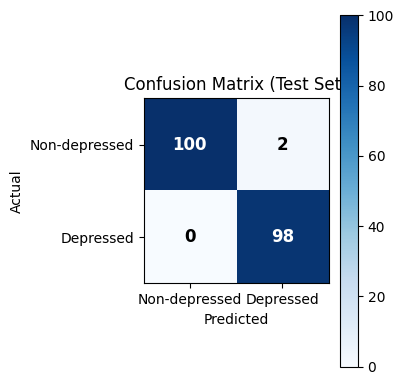

In [36]:
import torch
import librosa
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wav2vec_model.eval()

@torch.no_grad()
def predict_id(file_path, sr=16000, max_seconds=6.0):
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    y = y[: int(sr * max_seconds)]

    inputs = processor([y], sampling_rate=sr, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    logits = wav2vec_model(**inputs).logits
    return int(torch.argmax(logits, dim=-1).item())

# predictions
y_true = test_df["label"].astype(int).tolist()
y_pred = [predict_id(p) for p in test_df["file_path"].tolist()]

# ======================
# Classification Report
# ======================
print("\nClassification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=["Non-depressed", "Depressed"],
    digits=4
))

# ======================
# Confusion Matrix
# ======================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.colorbar()

classes = ["Non-depressed", "Depressed"]
plt.xticks([0,1], classes)
plt.yticks([0,1], classes)

# numbers inside cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i,j] > cm.max()/2 else "black",
                 fontsize=12,
                 fontweight="bold")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()